In [77]:
!pip -q install seaborn

In [1]:
import json
import itertools
import scipy
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import *
from collections import defaultdict
from utils import get_session_ids, get_all_sequences, get_topics, get_sub_topics, RegExp, product,to_matrix
from search_engine import *
from numpy.random import choice
from tqdm.notebook import tqdm
from multiprocessing import Pool

np.set_printoptions(precision=3)

# Data Preprocessing

In [2]:
path_log = './data/log.2.tsv'
path_topic = './data/topic.tsv'
path_sub_topic = './data/sub_topic.tsv'
path_retrievable_paragraph = './data/retrievable_paragraph.tsv'

In [3]:
session_ids = get_session_ids(path_log)
all_sequences = get_all_sequences(path_log, session_ids)

In [4]:
topics = get_topics(path_topic)

topics

{1: 'harvard university',
 2: 'black death',
 3: 'intergovernmental panel on climate change',
 4: 'private schools',
 5: 'geology',
 6: 'economic inequality',
 7: 'immune system',
 8: 'oxygen',
 9: 'normans',
 10: 'amazon rainforest',
 11: 'european union law'}

In [5]:
# topic -> sub_topic -> queries
all_queries = {}

for topic in all_sequences:
    
    queries = defaultdict(list)
    for sequence in all_sequences[topic]:
        for action in sequence:
            sub_topic = action[3]
            query = action[4]
            queries[sub_topic].append(query)
    
    all_queries[topic] = queries

all_queries

{2: defaultdict(list,
             {28: ['black death plague origin',
               'origins of black death',
               'black death history',
               'where did black death come from',
               'black death plague origins',
               'black death',
               'origins of black death',
               'plague',
               'historical background of black death',
               'where did the black plague come from',
               'black death origin',
               'black death origin',
               '"black death" origins',
               'black death origin',
               'black death origins',
               'black death',
               'black death',
               'disease',
               'skin patches',
               'origin of the black death',
               'what is black death',
               'black death',
               'black death origins',
               'bubonic plague',
               'black death origin',
               'origins 

In [6]:
# topic -> sub_topic -> paragraphs
qrels = defaultdict(dict)

sub_topic_to_paragraph = defaultdict(set)
with open(path_retrievable_paragraph) as f:
    for line in f.readlines()[1:]:
        items = line.split('\t')
        sub_topic = int(items[0])
        paragraph = int(items[1])
        sub_topic_to_paragraph[sub_topic].add(paragraph)

sub_topics = get_sub_topics(path_sub_topic)

for topic in sub_topics:
    for sub_topic in sub_topics[topic]:
        qrels[topic][sub_topic] = sub_topic_to_paragraph[sub_topic]

qrels

defaultdict(dict,
            {10: {1: {372, 374},
              2: {371},
              3: {379, 380, 381},
              4: {385, 386},
              5: {371}},
             5: {6: {496},
              7: {498, 499, 521},
              8: {501},
              9: {502, 503, 504, 521},
              10: {505, 511},
              11: {499, 521}},
             6: {12: {689, 699},
              13: {675, 676, 689},
              14: {675, 689, 699},
              15: {689, 699, 708, 713},
              16: {674, 675, 676},
              17: {675, 708}},
             4: {18: {607},
              19: {597},
              20: {597},
              21: {596},
              22: {596, 600},
              23: {599, 607},
              24: {600},
              25: {596, 619},
              26: {602},
              27: {602, 619}},
             2: {28: {474, 475, 480},
              29: {474, 475, 476, 477, 491},
              30: {483},
              31: {474, 475, 491, 495},
              32: {47

In [7]:
# from users continuos
# topic -> sub_topic -> paragraphs
qrels_users = {}

for topic in sub_topics:
    for sequence in all_sequences[topic]:
        for action in sequence:
            paragraph = action[1]
            rel = action[2]
            sub_topic = action[3]
            if topic not in qrels_users:
                qrels_users[topic] = {}
            if sub_topic not in qrels_users[topic]:
                qrels_users[topic][sub_topic] = {}
            if paragraph not in qrels_users[topic][sub_topic]:
                qrels_users[topic][sub_topic][paragraph] = (0, 0)
            num, den = qrels_users[topic][sub_topic][paragraph]
            if rel == 'relevant':
                qrels_users[topic][sub_topic][paragraph] = (num + 1, den + 1)
            else:
                qrels_users[topic][sub_topic][paragraph] = (num, den + 1)

for topic in qrels_users:
    for sub_topic in qrels_users[topic]:
        for paragraph in qrels_users[topic][sub_topic]:
            num, den = qrels_users[topic][sub_topic][paragraph]
            qrels_users[topic][sub_topic][paragraph] = num/den
            
qrels_users

{10: {5: {371: 0.5714285714285714},
  4: {386: 0.6551724137931034, 385: 1.0},
  2: {371: 0.95},
  1: {374: 0.8333333333333334, 372: 1.0},
  3: {380: 0.7222222222222222, 381: 0.7, 379: 1.0}},
 5: {10: {511: 0.9444444444444444},
  9: {521: 0.8235294117647058, 504: 0.6666666666666666, 502: 1.0},
  8: {501: 0.8},
  6: {496: 0.03125},
  7: {521: 0.42105263157894735, 499: 0.3333333333333333},
  11: {521: 0.6666666666666666, 499: 0.26666666666666666}},
 6: {13: {689: 1.0, 675: 0.8},
  15: {699: 0.75, 708: 1.0},
  16: {675: 0.9230769230769231, 674: 1.0},
  14: {675: 0.42857142857142855, 699: 1.0},
  17: {708: 1.0, 675: 0.4},
  12: {699: 0.5, 689: 1.0}},
 4: {22: {600: 0.6538461538461539},
  25: {619: 1.0, 596: 1.0},
  21: {596: 1.0},
  26: {602: 0.26666666666666666},
  20: {597: 0.5882352941176471},
  18: {607: 0.8421052631578947},
  19: {597: 0.2631578947368421},
  23: {607: 1.0},
  27: {602: 1.0},
  24: {600: 0.0}},
 2: {28: {474: 0.9583333333333334, 475: 0.6666666666666666},
  29: {474: 0.8

# Setup Search System

In [8]:
direct_index = DirectIndex.load()

In [9]:
pre_preocessor = PreProcessor()

def select_random_documents(documents:set, p:float=0.0):
    assert(0.0 <= p <= 1.0)
    if p == 0.0:
        return set()
    elif p == 1.0:
        return documents
    else:
        return set(choice(list(documents), replace=False, size = int(len(documents) * p)))
        
def get_search_engine(topic, sub_topic, qrels, direct_index, noise = 0.0):
    # select documents belonging to the topic
    selected_documents = {}
    for document in qrels[topic][sub_topic]:
        selected_documents[document] = direct_index.index[document]
        
    # select random documents
    # 1. from topic documents
    topic_documents = set()
    for _, sub_topic_documents in qrels[topic].items():
        topic_documents.update(sub_topic_documents)    
    topic_documents = select_random_documents(topic_documents, noise)
    
    for document in topic_documents:
        selected_documents[document] = direct_index.index[document]
    
    # 2. from all_documents
    all_documents = direct_index.index.keys()
    all_documents = select_random_documents(all_documents, noise)

    for document in all_documents:
        selected_documents[document] = direct_index.index[document]
        
    # retrievable documents
    inverted_index = InvertedIndex()
    inverted_index.create(selected_documents)
        
    return selected_documents, inverted_index

# stats
inverted_index = InvertedIndex()
inverted_index.create(direct_index.index)

# test
for topic in sub_topics:
    for sub_topic in sub_topics[topic]:
        print(topic, topics[topic], sub_topic)
        r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, direct_index, 0.01)
        print("over", len(r_documents), "documents")
        r_inverted_index.cl = inverted_index.cl
        r_inverted_index.dictionary = inverted_index.dictionary
        search = Search(r_inverted_index, pre_preocessor)
        print(search.search('amazon', n=2, retrievable_paragraphs=r_documents.keys()))
    break

10 amazon rainforest 1
over 204 documents
[374, 218]
10 amazon rainforest 2
over 203 documents
[371, 171]
10 amazon rainforest 3
over 205 documents
[381, 379]
10 amazon rainforest 4
over 204 documents
[386, 385]
10 amazon rainforest 5
over 203 documents
[371, 30]


# Correlation Analysis

In [10]:
# CP
def dd_cp(alpha, m, l):
    return 1

def ncp(sequence):
    res = 0.0
    for action in sequence:
        if action[2] == 'relevant':
            res += dd_cp(None, None, None)
    return res/len(sequence)

def get_ncp_list(sequences):
    res = []
    for sequence in sequences:
        res.append(ncp(sequence))
    return res

# CBP
def dd_cbp(alpha, m, l = None):
    return alpha ** m

def dd_ncbp(alpha, m, l):
    norm = 0.0
    for i in range(l):
        norm += dd_cbp(alpha, i, l)
    return dd_cbp(alpha, m, l) / norm

def ncbp(sequence, alpha):
    res = 0.0
    for m, action in enumerate(sequence):
        if action[2] == 'relevant':
            res += dd_ncbp(alpha, m, len(sequence))
    return res

def get_ncbp_list(sequences, alpha):
    res = []
    for sequence in sequences:
        res.append(ncbp(sequence, alpha))
    return res

# ECS
def dd_necs(alpha_rel, alpha_irr, m, sequence):
    res = 1.0
    for action in sequence[:m]:
        if action[2] == 'relevant':
            res *= alpha_rel
        else:
            res *= alpha_irr
    norm = 0.0
    for i in range(len(sequence)):
        norm += dd_cbp(alpha_rel, i)
    return res / norm

def necs(sequence, alpha_rel, alpha_irr):
    res = 0.0
    for m, action in enumerate(sequence):
        if action[2] == 'relevant':
            res += dd_necs(alpha_rel, alpha_irr, m, sequence)
    return res

def get_necs_list(sequences, alpha_rel, alpha_irr):
    res = []
    for sequence in sequences:
        res.append(necs(sequence, alpha_rel, alpha_irr))
    return res

In [11]:
necs_scores = []
ncbp_scores = []
ncp_scores = []

for topic in topics:
    sequences = all_sequences[topic]
    necs_scores.append((topic, np.mean(get_necs_list(sequences, 1.0, 0.53))))
    ncbp_scores.append((topic, np.mean(get_ncbp_list(sequences, 0.8))))
    ncp_scores.append((topic, np.mean(get_ncp_list(sequences))))
    
necs_scores = sorted(necs_scores)
ncbp_scores = sorted(ncbp_scores)
ncp_scores = sorted(ncp_scores)

necs_scores, ncbp_scores, ncp_scores

([(1, 0.5949149948784092),
  (2, 0.7452044516941393),
  (3, 0.9001587301587302),
  (4, 0.5888685146609386),
  (5, 0.33085733303643083),
  (6, 0.6460987394957984),
  (7, 0.8091102513227513),
  (8, 0.4860983162324491),
  (9, 0.7415645642366748),
  (10, 0.7312925580761744),
  (11, 0.5859629384756658)],
 [(1, 0.7595064540941862),
  (2, 0.8691201000455874),
  (3, 0.9348839315112955),
  (4, 0.7242295894639852),
  (5, 0.5443612168885348),
  (6, 0.7895318053172284),
  (7, 0.8927703848651795),
  (8, 0.6647962142197922),
  (9, 0.8533338028413104),
  (10, 0.8661807080306712),
  (11, 0.7338230922441551)],
 [(1, 0.7848484848484848),
  (2, 0.8576159951159952),
  (3, 0.9197420634920634),
  (4, 0.7154244306418218),
  (5, 0.5163437439753228),
  (6, 0.7873949579831933),
  (7, 0.8865079365079365),
  (8, 0.6220760233918129),
  (9, 0.8343411796536796),
  (10, 0.8211020863194777),
  (11, 0.7407254361799815)])

In [12]:
def get_satisfaction(lines):
    reg_exp = RegExp()
    satisfaction = None
    for line in lines:
        items = line.split('\t')
        content = items[2]
        if reg_exp.get(r'user is (.+)', content):
            satisfaction = reg_exp.res
    return satisfaction

def get_all_satisfactions(path_log, session_ids):
    res = defaultdict(list)
    for session_id in session_ids:
        selected_lines = []
        with open(path_log) as f:
            for line in f.readlines()[1:]:
                items = line.split('\t')
                user = items[3].strip()
                topic = int(items[4].strip())
                if user == session_id[0] and topic == session_id[1]:
                    selected_lines.append(line)

        satisfaction = get_satisfaction(selected_lines)
        res[session_id[1]].append(satisfaction)
    return res

all_satisfactions = get_all_satisfactions(path_log, session_ids)

satisfaction_scores = []
for topic in topics:
    satisfactions = all_satisfactions[topic]
    satisfaction_score = 0.0
    for satisfaction in satisfactions:
        if satisfaction == 'satisfied':
            satisfaction_score += 1
    satisfaction_score /= len(satisfactions)
    satisfaction_scores.append((topic, satisfaction_score))

satisfaction_scores = sorted(satisfaction_scores)
satisfaction_scores

[(1, 0.7272727272727273),
 (2, 0.7692307692307693),
 (3, 0.875),
 (4, 0.7391304347826086),
 (5, 0.47368421052631576),
 (6, 0.7647058823529411),
 (7, 0.8888888888888888),
 (8, 0.5789473684210527),
 (9, 0.6875),
 (10, 0.7391304347826086),
 (11, 0.6363636363636364)]

KendalltauResult(correlation=0.7339758434175737, pvalue=0.001787289036987269)
SpearmanrResult(correlation=0.870161710874372, pvalue=0.0004954180897534654)
(0.9087589613730385, 0.0001072867497745465)


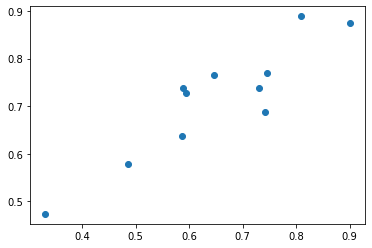

In [13]:
plt.plot([i[1] for i in necs_scores], [i[1] for i in satisfaction_scores], 'o')
print(kendalltau([i[1] for i in necs_scores], [i[1] for i in satisfaction_scores]))
print(spearmanr([i[1] for i in necs_scores], [i[1] for i in satisfaction_scores]))
print(pearsonr([i[1] for i in necs_scores], [i[1] for i in satisfaction_scores]))

KendalltauResult(correlation=0.7339758434175737, pvalue=0.001787289036987269)
SpearmanrResult(correlation=0.8610500699228079, pvalue=0.0006630680655063411)
(0.8952368820424177, 0.00019583986261185313)


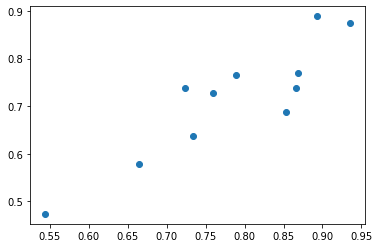

In [14]:
plt.plot([i[1] for i in ncbp_scores], [i[1] for i in satisfaction_scores], 'o')
print(kendalltau([i[1] for i in ncbp_scores], [i[1] for i in satisfaction_scores]))
print(spearmanr([i[1] for i in ncbp_scores], [i[1] for i in satisfaction_scores]))
print(pearsonr([i[1] for i in ncbp_scores], [i[1] for i in satisfaction_scores]))

KendalltauResult(correlation=0.697277051246695, pvalue=0.0030042622393982835)
SpearmanrResult(correlation=0.8382709675438977, pvalue=0.0012683508950782564)
(0.9178106884834428, 6.794784339952218e-05)


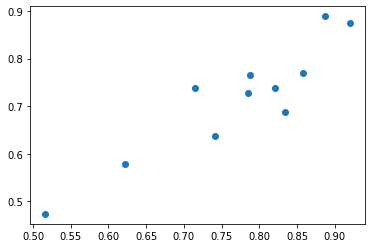

In [15]:
plt.plot([i[1] for i in ncp_scores], [i[1] for i in satisfaction_scores], 'o')
print(kendalltau([i[1] for i in ncp_scores], [i[1] for i in satisfaction_scores]))
print(spearmanr([i[1] for i in ncp_scores], [i[1] for i in satisfaction_scores]))
print(pearsonr([i[1] for i in ncp_scores], [i[1] for i in satisfaction_scores]))

# Simulations

In [16]:
num_samples = 100000

In [17]:
def generate_sequence(num_subtopics, min_sub_topics = 1):
    prob = 1.0
    sequence = []
    current_subtopic = 0
    
    next_subtopic = choice(range(1, num_subtopics + 1), 1)[0]
    prob *= 1.0/num_subtopics
    sequence.append((current_subtopic, None, None, next_subtopic + min_sub_topics - 1, None))
    current_subtopic = next_subtopic
    
    while next_subtopic + min_sub_topics - 1 != num_subtopics + 1 + min_sub_topics - 1:
        next_subtopic = choice(range(1, num_subtopics + 2), 1)[0]
        prob *= 1.0/(num_subtopics + 1)
        sequence.append((current_subtopic + min_sub_topics - 1, 
                         None, None, 
                         next_subtopic + min_sub_topics - 1, None))
        current_subtopic = next_subtopic
        
    return sequence, prob

sequence, prob = generate_sequence(5)

print(sequence)

[(0, None, None, 4, None), (4, None, None, 4, None), (4, None, None, 2, None), (2, None, None, 2, None), (2, None, None, 5, None), (5, None, None, 3, None), (3, None, None, 4, None), (4, None, None, 4, None), (4, None, None, 5, None), (5, None, None, 4, None), (4, None, None, 2, None), (2, None, None, 3, None), (3, None, None, 1, None), (1, None, None, 4, None), (4, None, None, 1, None), (1, None, None, 2, None), (2, None, None, 1, None), (1, None, None, 3, None), (3, None, None, 5, None), (5, None, None, 3, None), (3, None, None, 3, None), (3, None, None, 3, None), (3, None, None, 3, None), (3, None, None, 4, None), (4, None, None, 6, None)]


In [18]:
def get_transitions_table(num_subtopics, min_sub_topic, sequences, epsilon = 0.0):
    transitions_table = defaultdict(float)
    for sequence in sequences:
        last_key = None
        for n, action in enumerate(sequence):
            if n == 0:
                key = (action[0], action[3] - min_sub_topic + 1)
            else:
                key = (action[0] - min_sub_topic + 1, action[3] - min_sub_topic + 1)
            transitions_table[key] += 1
            last_key = key
        transitions_table[(last_key[1], num_subtopics+1)] += 1
    
    norms = defaultdict(float)
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if not (from_subtopic == 0 and to_subtopic == num_subtopics + 1):            
            transitions_table[(from_subtopic, to_subtopic)] += epsilon
        norms[from_subtopic] += transitions_table[(from_subtopic, to_subtopic)]
    
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if norms[from_subtopic] > 0.0:
            transitions_table[(from_subtopic, to_subtopic)] /= norms[from_subtopic]
            
    return transitions_table

def generate_sequence_from_table(num_subtopics, min_sub_topics, table):
    prob = 1.0
    table = to_matrix(table)
    sequence = []
    current_subtopic = 0
    
    next_subtopic = choice(range(1, num_subtopics + 2), 1, p=table[0])[0]
    prob *= table[0, next_subtopic - 1]
    sequence.append((current_subtopic, None, None, next_subtopic + min_sub_topics - 1, None))
    current_subtopic = next_subtopic
    
    while next_subtopic + min_sub_topics - 1 != num_subtopics + 1 + min_sub_topics - 1:
        next_subtopic = choice(range(1, num_subtopics + 2), 1, p=table[current_subtopic])[0]
        prob *= table[current_subtopic, next_subtopic-1]
        sequence.append((current_subtopic + min_sub_topics - 1, 
                         None, None, 
                         next_subtopic + min_sub_topics - 1, None))
        current_subtopic = next_subtopic
    
    return sequence, prob

In [19]:
def get_transitions_tables(num_subtopics, min_sub_topic, sequences, epsilon = 0.0):
    rel_transitions_table = defaultdict(float)
    irr_transitions_table = defaultdict(float)
    p_rel = defaultdict(float)
    p_irr = defaultdict(float)
    for sequence in sequences:
        last_key = None
        last_rel = 'irrelevant'
        for n, action in enumerate(sequence):
            if n == 0:
                key = (action[0], action[3] - min_sub_topic + 1)
            else:
                key = (action[0] - min_sub_topic + 1, action[3] - min_sub_topic + 1)
            if last_rel == 'relevant':
                rel_transitions_table[key] += 1
                p_rel[key[0]] += 1
            else:
                irr_transitions_table[key] += 1
                p_irr[key[0]] += 1
            last_key = key
            last_rel = action[2]
        
        if last_rel == 'relevant':
            rel_transitions_table[(last_key[1], num_subtopics+1)] += 1
            p_rel[last_key[1]] += 1
        else:
            irr_transitions_table[(last_key[1], num_subtopics+1)] += 1
            p_irr[last_key[1]] += 1
        
    rel_norms = defaultdict(float)
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if from_subtopic > 0:            
            rel_transitions_table[(from_subtopic, to_subtopic)] += epsilon
        rel_norms[from_subtopic] += rel_transitions_table[(from_subtopic, to_subtopic)]
    
    irr_norms = defaultdict(float)
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if not (from_subtopic == 0 and to_subtopic == num_subtopics + 1):
            irr_transitions_table[(from_subtopic, to_subtopic)] += epsilon
        irr_norms[from_subtopic] += irr_transitions_table[(from_subtopic, to_subtopic)]
    
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if rel_norms[from_subtopic] > 0.0:
            rel_transitions_table[(from_subtopic, to_subtopic)] /= (rel_norms[from_subtopic]) 
    
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if irr_norms[from_subtopic] > 0.0:
            irr_transitions_table[(from_subtopic, to_subtopic)] /= (irr_norms[from_subtopic])
    
    p = []
    for t in range(num_subtopics + 1):
        if (p_rel[t] + p_irr[t]) > 0:
            p.append(p_rel[t]/(p_rel[t] + p_irr[t]))
        else:
            p.append(0.0)
    p = np.array([p])

    return rel_transitions_table, irr_transitions_table, p, 1 - p

In [20]:
class SequenceGenerator:
    
    def __init__(self, num_subtopics, min_sub_topic, rel_table, irr_table):
        self.num_subtopics = num_subtopics
        self.rel_table = to_matrix(rel_table)
        self.irr_table = to_matrix(irr_table)
        self.min_sub_topic = min_sub_topic
        self.relevance = False
        self.current_subtopic = 0
        
    def __iter__(self):
        #self.current_subtopic = 0
        return self
    
    def set_relevance(self, relevance):
        self.relevance = relevance
    
    def __next__(self):
        next_subtopic = -1
        prob = -1
        if self.current_subtopic + self.min_sub_topic - 1 == self.num_subtopics + 1 + self.min_sub_topic - 1:
            raise StopIteration
        if self.relevance:
            #print(self.rel_table[self.current_subtopic].sum())
            next_subtopic = choice(range(1, self.num_subtopics + 2), 
                                   1, 
                                   p=self.rel_table[self.current_subtopic])[0]
            prob = self.rel_table[self.current_subtopic, next_subtopic - 1]
        else:
            #print(self.irr_table[self.current_subtopic].sum())
            next_subtopic = choice(range(1, self.num_subtopics + 2), 
                                   1, 
                                   p=self.irr_table[self.current_subtopic])[0]
            prob = self.irr_table[self.current_subtopic, next_subtopic - 1]
        self.current_subtopic = next_subtopic
        return next_subtopic + self.min_sub_topic - 1, prob

## Errors

In [21]:
def ltse(d1, d2):
    err = 0.0
    M = len(d1)
    if len(d1) < len(d2):
        d1, d2 = d2, d1
    for i in range(len(d1)):
        if i < len(d2):
            err += (d1[i]-d2[i])**2   
        else:
            err += (d1[i])**2
    return np.log(err)

def ltae(d1, d2):
    err = 0.0
    M = len(d1)
    if len(d1) < len(d2):
        d1, d2 = d2, d1
    for i in range(len(d1)):
        if i < len(d2):
            err += abs(d1[i]-d2[i])
        else:
            err += abs(d1[i])
    return np.log(err)

def kl(d1, d2):
    err = 0.0
    M = len(d1)
    for i in range(len(d1)):
        err += -d1[i]*np.log(d2[i]/d1[i])
    return err

In [136]:
gp = defaultdict(int)
for topic in all_sequences:
    for sequence in all_sequences[topic]:
        for m, _ in enumerate(sequence):
            gp[m] += 1

ngp = np.array([value for key, value in gp.items()])
ngp = ngp / np.sum(ngp)

ngp

array([0.184, 0.167, 0.159, 0.143, 0.118, 0.081, 0.054, 0.035, 0.023,
       0.012, 0.008, 0.005, 0.005, 0.004, 0.002])

In [137]:
def dd_cp(alpha, beta, m, sequence, acc_value = 1.0):
    return 1

def dd_cbp(alpha, beta, m, sequence, acc_value = 1.0):
    if m == 0:
        return 1.0
    else:
        res = acc_value*alpha
        return res
    
def dd_ecs(alpha_rel, alpha_irr, m, sequence, acc_value = 1.0):
    if m == 0:
        return 1.0
    else:
        res = acc_value
        action = sequence[m]
        if action[2] == 'relevant':
            res *= alpha_rel
        else:
            res *= alpha_irr
        return res

## Uniform Simulations

In [138]:
def get_sequences(get_sequences_topic):
    res = {}
    pool = Pool(processes=11)
    pool_res = pool.map(get_sequences_topic, sub_topics)
    pool.terminate()
    for topic, sequences in pool_res:
        res[topic] = sequences        
    return res

In [139]:
def get_uniform_sequences_topic(topic):    
    all_r_documents = {}
    all_r_inverted_index = {}
    for sub_topic in sub_topics[topic]:
        r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, direct_index)
        all_r_documents[sub_topic] = r_documents
        all_r_inverted_index[sub_topic] = r_inverted_index

    sequences = []
    for _ in range(num_samples):
        sequence, prob = generate_sequence(len(sub_topics[topic]), min(sub_topics[topic]))
        for m, action in enumerate(sequence[:-1]):
            query = ''
            if sub_topic in all_queries[topic] and len(all_queries[topic][sub_topic]) > 0: 
                queries = all_queries[topic][sub_topic]
                query = queries[choice(range(len(queries)))]

            search = Search(all_r_inverted_index[sub_topic], pre_preocessor)
            answer = search.search(query, n=1, retrievable_paragraphs=all_r_documents[sub_topic].keys())[0]

            if sub_topic in qrels_users[topic] and answer in qrels_users[topic][sub_topic] and \
            np.random.uniform(0,1) < qrels_users[topic][sub_topic][answer]:
                sequence[m] = (action[0], answer, 'relevant', action[3], query)
            else:
                sequence[m] = (action[0], answer, 'irrelevant', action[3], query)

        sequences.append((sequence[:-1], prob))

    return topic, sequences
        
all_uniform_sequences = get_sequences(get_uniform_sequences_topic)

In [140]:
def get_dist(all_sequences, alpha, beta, dd):
    res = defaultdict(float)
    n = defaultdict(float)
    for topic in sub_topics:
        for sequence, prob in all_sequences[topic]:
            score = 1.0
            for m, _ in enumerate(sequence):
                score = dd(alpha, beta, m, sequence, score)
                res[m] += score
                n[m] += 1
    
    for m in res:
        res[m] /= n[m]
    
    nres = np.array([value for key, value in res.items()])
    nres = nres / np.sum(nres)
    return nres

In [141]:
ngp_u_cp = get_dist(all_uniform_sequences, None, None, dd_cp)
print("CP, KL", kl(ngp, ngp_u_cp))
print("CP, LTSE", ltse(ngp, ngp_u_cp))
print("CP, LTAE", ltae(ngp, ngp_u_cp))

CP, KL 2.5943530968169055
CP, LTSE -2.083150865992216
CP, LTAE 0.5779736685968784


In [144]:
res = 100
max_alpha = 0.0
max_kl = 1.0
ngp_u_cbp = None
for alpha in tqdm(range(0, res+1)):
    alpha /= res

    ngp_u = get_dist(all_uniform_sequences, alpha, None, dd_cbp)

    score = kl(ngp, ngp_u)
    if score < max_kl:
        max_kl = score
        max_alpha = alpha
        ngp_u_cbp = ngp_u

print("CBP, KL", kl(ngp, ngp_u_cbp), max_alpha)
print("CP, LTSE", ltse(ngp, ngp_u_cp))
print("CBP, LTAE", ltae(ngp, ngp_u_cbp))

/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log



CBP, KL 0.05097818864405728 0.75
CP, LTSE -2.083150865992216
CBP, LTAE -1.3626105070861678


In [145]:
res = 100

def get_ngp_uniform_ecs(alphas):
    alpha_rel, alpha_irr = alphas
    return alpha_rel, alpha_irr, get_dist(all_uniform_sequences, alpha_rel/res, alpha_irr/res, dd_ecs)

alphas = list(itertools.product(range(0, res+1), repeat=2))
pool = Pool(50)
pool_res = list(tqdm(pool.imap_unordered(get_ngp_uniform_ecs, alphas, chunksize=1), total=len(alphas)))
pool.terminate()

max_alpha_rel = 0.0
max_alpha_irr = 0.0
max_kl = 1.0
ngp_u_ecs = None
for alpha_rel, alpha_irr, ngp_u in pool_res:
    score = kl(ngp, ngp_u)
    if score < max_kl:
        max_kl = score
        max_alpha_rel = alpha_rel/res
        max_alpha_irr = alpha_irr/res
        ngp_u_ecs = ngp_u

print("CBP, KL", kl(ngp, ngp_u_ecs), max_alpha_rel, max_alpha_irr)
print("CP, LTSE", ltse(ngp, ngp_u_cp))
print("CBP, LTAE", ltae(ngp, ngp_u_ecs))

/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log


CBP, KL 0.04912501323539883 0.73 0.82
CP, LTSE -2.083150865992216
CBP, LTAE -1.3657073782187377


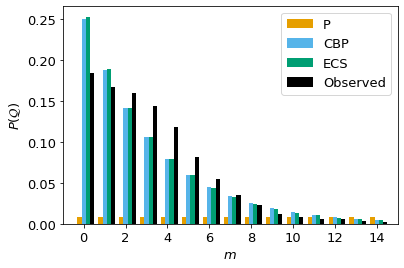

In [146]:
x = np.arange(ngp.shape[0])

bar_width = 0.20

plt.bar(x-bar_width*1, ngp_u_cp[0:len(x)], width = bar_width, color='#E69F00', align='center', label='P')
plt.bar(x+bar_width*0, ngp_u_cbp[0:len(x)], width = bar_width, color='#56B4E9', align='center', label='CBP')
plt.bar(x+bar_width*1, ngp_u_ecs[0:len(x)], width = bar_width, color='#009E73', align='center', label="ECS")
plt.bar(x+bar_width*2, ngp, width = bar_width, color='black', align='center', label="Observed")

#plt.rc('font', size=13)
plt.ylabel('$P(\\mathcal{Q})$')
plt.xlabel('$m$')
plt.xlim(-1, 15)
plt.legend()
#plt.savefig("probability_of_querying.png", dpi=300)

## Markov Simulations

In [147]:
def get_table_sequences_topic(topic):
    all_r_documents = {}
    all_r_inverted_index = {}
    for sub_topic in sub_topics[topic]:
        r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, direct_index)
        all_r_documents[sub_topic] = r_documents
        all_r_inverted_index[sub_topic] = r_inverted_index

    transitions_table = get_transitions_table(len(sub_topics[topic]), 
                                              min(sub_topics[topic]), 
                                              all_sequences[topic])

    sequences = []
    for _ in range(num_samples):
        sequence, prob = generate_sequence_from_table(len(sub_topics[topic]), 
                                                      min(sub_topics[topic]), 
                                                      transitions_table)
        for m, action in enumerate(sequence[:-1]):
            query = ''
            if sub_topic in all_queries[topic] and len(all_queries[topic][sub_topic]) > 0:
                queries = all_queries[topic][sub_topic]
                query = queries[choice(range(len(queries)))]

            search = Search(all_r_inverted_index[sub_topic], pre_preocessor)
            answer = search.search(query, 
                                   n=1, 
                                   retrievable_paragraphs=all_r_documents[sub_topic].keys())[0]

            if sub_topic in qrels_users[topic] and answer in qrels_users[topic][sub_topic] and \
            np.random.uniform(0,1) < qrels_users[topic][sub_topic][answer]:
                sequence[m] = (action[0], answer, 'relevant', action[3], query)
            else:
                sequence[m] = (action[0], answer, 'irrelevant', action[3], query)

        sequences.append((sequence[:-1], prob))

    return topic, sequences

all_table_sequences = get_sequences(get_table_sequences_topic)

In [148]:
ngp_t_cp = get_dist(all_table_sequences, None, None, dd_cp)
print("CP, KL", kl(ngp, ngp_t_cp))
print("CP, LTSE", ltse(ngp, ngp_t_cp))
print("CP, LTAE", ltae(ngp, ngp_t_cp))

CP, KL 2.356267965504498
CP, LTSE -2.101612867572381
CP, LTAE 0.5520793178117048


In [149]:
res = 100
max_alpha = 0.0
max_kl = 1.0
ngp_t_cbp = None
for alpha in tqdm(range(0, res + 1)):
    alpha /= res

    ngp_t = get_dist(all_table_sequences, alpha, None, dd_cbp)

    score = kl(ngp, ngp_t)
    if score < max_kl:
        max_kl = score
        max_alpha = alpha
        ngp_t_cbp = ngp_t

print("CBP, KL", kl(ngp, ngp_t_cbp), max_alpha)
print("CBP, LTSE", ltse(ngp, ngp_t_cbp), max_alpha)
print("CBP, LTAE", ltae(ngp, ngp_t_cbp))

/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log



CBP, KL 0.05097818864165624 0.75
CBP, LTSE -4.738355749374781 0.75
CBP, LTAE -1.3626105070948415


In [159]:
res = 100

def get_ngp_table_ecs(alphas):
    alpha_rel, alpha_irr = alphas
    return alpha_rel, alpha_irr, get_dist(all_table_sequences, 
                                 alpha_rel/res, alpha_irr/res, dd_ecs)

alphas = list(itertools.product(range(0, res+1), repeat=2))
pool = Pool(32)
pool_res = list(tqdm(pool.imap_unordered(get_ngp_table_ecs, alphas, chunksize=1), total=len(alphas)))
pool.terminate()

max_alpha = 0.0
max_beta = 0.0
max_kl = 1.0
ngp_t_ecs = None
for alpha_rel, alpha_irr, ngp_t in pool_res:    
    score = kl(ngp, ngp_t)
    if score < max_kl:
        max_kl = score
        max_alpha_rel = alpha_rel/res
        max_alpha_irr = alpha_irr/res
        ngp_t_ecs = ngp_t

print("CBP, KL", kl(ngp, ngp_t_ecs), max_alpha_rel, max_alpha_irr)
print("CBP, LTSE", ltse(ngp, ngp_t))
print("CBP, LTAE", ltae(ngp, ngp_t_ecs))

/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log


CBP, KL 0.04885653800326699 0.77 0.67
CBP, LTSE -2.101612867572381
CBP, LTAE -1.3653907150934628


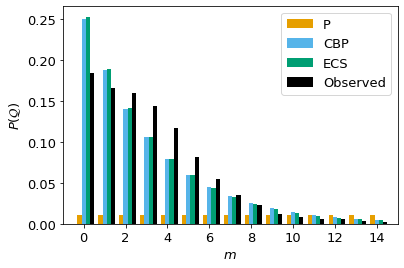

In [160]:
x = np.arange(ngp.shape[0])

bar_width = 0.20

plt.bar(x-bar_width*1, ngp_t_cp[0:len(x)], width = bar_width, color='#E69F00', align='center', label='P')
plt.bar(x+bar_width*0, ngp_t_cbp[0:len(x)], width = bar_width, color='#56B4E9', align='center', label='CBP')
plt.bar(x+bar_width*1, ngp_t_ecs[0:len(x)], width = bar_width, color='#009E73', align='center', label="ECS")
plt.bar(x+bar_width*2, ngp, width = bar_width, color='black', align='center', label="Observed")

#plt.rc('font', size=13)
plt.ylabel('$P(\\mathcal{Q})$')
plt.xlabel('$m$')
plt.xlim(-1, 15)
plt.legend()
#plt.savefig("probability_of_querying.png", dpi=300)

## Markov + Simulation

In [161]:
def get_double_table_sequences_topic(topic):
    num_subtopics = len(sub_topics[topic])

    all_r_documents = {}
    all_r_inverted_index = {}
    for sub_topic in sub_topics[topic]:
        r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, direct_index)
        all_r_documents[sub_topic] = r_documents
        all_r_inverted_index[sub_topic] = r_inverted_index

    rel_table, irr_table, p_rel, _ = get_transitions_tables(num_subtopics, 
                                                            min(sub_topics[topic]), 
                                                            all_sequences[topic], 
                                                            0.0)
    sequences = []
    for _ in range(num_samples):
        sg = SequenceGenerator(num_subtopics, min(sub_topics[topic]), rel_table, irr_table)
        prob = 1.0
        prev_sub_topic = 0
        sequence = []
        for m, (sub_topic, prob_action) in enumerate(sg):
            
            if sub_topic != num_subtopics + 1 + min(sub_topics[topic]) - 1:
                query = ''
                if sub_topic in all_queries[topic] and len(all_queries[topic][sub_topic]) > 0: 
                    queries = all_queries[topic][sub_topic]
                    query = queries[choice(range(len(queries)))]

                search = Search(all_r_inverted_index[sub_topic], pre_preocessor)
                answer = search.search(query, 
                                       n=1, 
                                       retrievable_paragraphs=all_r_documents[sub_topic].keys())[0]

                if sub_topic in qrels_users[topic] and answer in qrels_users[topic][sub_topic] and \
                np.random.uniform(0,1) < qrels_users[topic][sub_topic][answer]:
                    sg.set_relevance(True)
                    sequence.append((prev_sub_topic, answer, 'relevant', sub_topic, query))
                else:
                    sg.set_relevance(False)
                    sequence.append((prev_sub_topic, answer, 'irrelevant', sub_topic, query))
                    
            prev_sub_topic = sub_topic
            prob *= prob_action

        sequences.append((sequence, prob))
    return topic, sequences

all_double_table_sequences = get_sequences(get_double_table_sequences_topic)

In [162]:
ngp_t2_cp = get_dist(all_double_table_sequences, None, None, dd_cp)
print("CP, KL", kl(ngp, ngp_t2_cp))
print("CP, LTSE", ltse(ngp, ngp_t2_cp))
print("CP, LTAE", ltae(ngp, ngp_t2_cp))

CP, KL 2.1674738942049254
CP, LTSE -2.1200572522633316
CP, LTAE 0.5276803869789499


In [163]:
res = 100
max_alpha = 0.0
max_kl = 1.0
ngp_t2_cbp = None
for alpha in tqdm(range(0, res+1)):
    alpha /= res

    ngp_t2 = get_dist(all_double_table_sequences, alpha, None, dd_cbp)

    score = ltse(ngp, ngp_t2)
    if score < max_kl:
        max_kl = score
        max_alpha = alpha
        ngp_t2_cbp = ngp_t2

print("CBP, KL", kl(ngp, ngp_t2_cbp), max_alpha)
print("CBP, LTSE", ltse(ngp, ngp_t2_cbp)) 
print("CBP, LTAE", ltae(ngp, ngp_t2_cbp))


CBP, KL 0.07343145324059414 0.79
CBP, LTSE -5.226785288520959
CBP, LTAE -1.3926196549951135


In [164]:
res = 100

def get_ngp_double_table_ecs(alphas):
    alpha_rel, alpha_irr = alphas
    return alpha_rel, alpha_irr, get_dist(all_double_table_sequences, alpha_rel/res, alpha_irr/res, dd_ecs)

alphas = list(itertools.product(range(0, res+1), repeat=2))
pool = Pool(32)
pool_res = list(tqdm(pool.imap_unordered(get_ngp_double_table_ecs, alphas, chunksize=1), total=len(alphas)))
pool.terminate()

max_alpha_rel = 0.0
max_alpha_irr = 0.0
max_kl = 1.0
ngp_t2_ecs = None
for alpha_rel, alpha_irr, ngp_t2 in pool_res:
    score = kl(ngp, ngp_t2)
    if score < max_kl:
        max_kl = score
        max_alpha_rel = alpha_rel/res
        max_alpha_irr = alpha_irr/res
        ngp_t2_ecs = ngp_t2

print("ECS, KL", kl(ngp, ngp_t2_ecs), max_alpha_rel, max_alpha_irr)
print("ECS, LTSE", ltse(ngp, ngp_t2_ecs))
print("ECS, LTAE", ltae(ngp, ngp_t2_ecs))

/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log


CBP, KL 0.0481552009176676 0.8 0.61
CBP, LTSE -4.7190493282911214
CBP, LTAE -1.3746966542414445


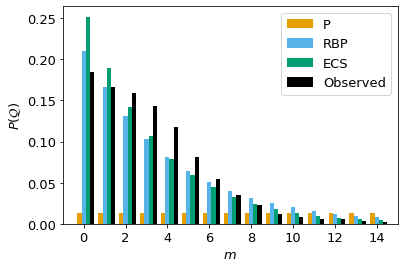

In [165]:
x = np.arange(ngp.shape[0])

bar_width = 0.20

plt.bar(x-bar_width*1, ngp_t2_cp[0:len(x)], width = bar_width, color='#E69F00', align='center', label='P')
plt.bar(x+bar_width*0, ngp_t2_cbp[0:len(x)], width = bar_width, color='#56B4E9', align='center', label='RBP')
plt.bar(x+bar_width*1, ngp_t2_ecs[0:len(x)], width = bar_width, color='#009E73', align='center', label="ECS")
plt.bar(x+bar_width*2, ngp, width = bar_width, color='black', align='center', label="Observed")

#plt.rc('font', size=13)
plt.ylabel('$P(\\mathcal{Q})$')
plt.xlabel('$m$')
plt.xlim(-1, 15)
plt.legend()
plt.savefig("probability_of_querying_sim.png", dpi=300)

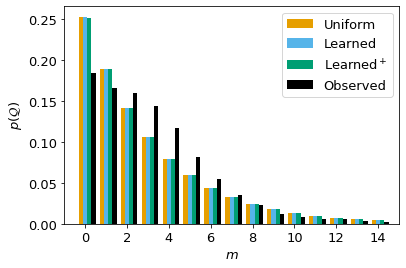

In [166]:
x = np.arange(ngp.shape[0])

bar_width = 0.20

plt.bar(x-bar_width*1, ngp_u_ecs[0:len(x)], width = bar_width, color='#E69F00', align='center', label='Uniform')
plt.bar(x+bar_width*0, ngp_t_ecs[0:len(x)], width = bar_width, color='#56B4E9', align='center', label='Learned')
plt.bar(x+bar_width*1, ngp_t2_ecs[0:len(x)], width = bar_width, color='#009E73', align='center', label="Learned$^+$")
plt.bar(x+bar_width*2, ngp, width = bar_width, color='black', align='center', label="Observed")

#plt.rc('font', size=13)
plt.ylabel('$p(\\mathcal{Q})$')
plt.xlabel('$m$')
plt.xlim(-1, 15)
plt.legend()
#plt.savefig("probability_of_querying_sim.png", dpi=300)

# Correlation Analysis with Satisfaction

In [35]:
# CP

def dd_cp(alpha, m, l):
    return 1

def ncp(sequence):
    res = 0.0
    for action in sequence:
        if action[2] == 'relevant':
            res += dd_cp(None, None, None)
    return res/len(sequence)

def get_ncp_list(sequences):
    res = []
    for sequence, _ in sequences:
        res.append(ncp(sequence))
    return res

# CBP

def dd_cbp(alpha, m, l = None):
    return alpha ** m

def dd_ncbp(alpha, m, l):
    return dd_cbp(alpha, m, l)

def ncbp(sequence, alpha):
    norm = 0.0
    for i in range(len(sequence)):
        norm += dd_cbp(alpha, i, len(sequence))
    res = 0.0
    for m, action in enumerate(sequence):
        if action[2] == 'relevant':
            res += dd_ncbp(alpha, m, len(sequence))
    return res/norm

def get_ncbp_list(sequences, alpha):
    res = []
    for sequence, _ in sequences:
        res.append(ncbp(sequence, alpha))
    return res

# ECS

def dd_necs(alpha_rel, alpha_irr, m, sequence):
    res = 1.0
    for action in sequence[:m]:
        if action[2] == 'relevant':
            res *= alpha_rel
        else:
            res *= alpha_irr
    return res

def necs(sequence, alpha_rel, alpha_irr):
    norm = 0.0
    for i in range(len(sequence)):
        norm += dd_cbp(alpha_rel, i)
    res = 0.0
    for m, action in enumerate(sequence):
        if action[2] == 'relevant':
            res += dd_necs(alpha_rel, alpha_irr, m, sequence)
    return res/norm

def get_necs_list(sequences, alpha_rel, alpha_irr):
    res = []
    for sequence, prob in sequences:
        res.append(necs(sequence, alpha_rel, alpha_irr))
    return res

In [168]:
ncp_t2_scores = []
ncp_t_scores = []
ncp_u_scores = []

ncbp_t2_scores = []
ncbp_t_scores = []
ncbp_u_scores = []

necs_t2_scores = []
necs_t_scores = []
necs_u_scores = []

print("Uniform")
for topic in tqdm(sorted(topics)):
    sequences = all_uniform_sequences[topic]
    if(len(sequences) > 0):
        ncp_u_scores.append((topic, get_ncp_list(sequences)))
        ncbp_u_scores.append((topic, get_ncbp_list(sequences, 0.75)))
        necs_u_scores.append((topic, get_necs_list(sequences, 0.73, 0.82)))

print("Learned")
for topic in tqdm(sorted(topics)):
    sequences = all_table_sequences[topic]
    if(len(sequences) > 0):
        ncp_t_scores.append((topic, get_ncp_list(sequences)))
        ncbp_t_scores.append((topic, get_ncbp_list(sequences, 0.75)))
        necs_t_scores.append((topic, get_necs_list(sequences, 0.77, 0.67)))

print("Learned+")
for topic in tqdm(sorted(topics)):
    sequences = all_double_table_sequences[topic]
    if(len(sequences) > 0):
        ncp_t2_scores.append((topic, get_ncp_list(sequences)))
        ncbp_t2_scores.append((topic, get_ncbp_list(sequences, 0.79)))
        necs_t2_scores.append((topic, get_necs_list(sequences, 0.80, 0.61)))

Uniform



Learned



Learned+


In [169]:
def unpack(l):
    return [np.mean(i[1]) for i in l]

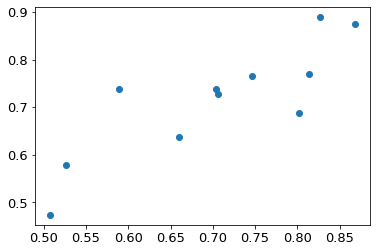

In [170]:
plt.plot(unpack(necs_t2_scores), unpack(satisfaction_scores), 'o')

In [171]:
print(scipy.stats.kendalltau(unpack(ncp_t2_scores), unpack(satisfaction_scores)))
print(scipy.stats.kendalltau(unpack(ncp_t_scores),  unpack(satisfaction_scores)))
print(scipy.stats.kendalltau(unpack(ncp_u_scores),  unpack(satisfaction_scores)))
print()
print(scipy.stats.kendalltau(unpack(ncbp_t2_scores), unpack(satisfaction_scores)))
print(scipy.stats.kendalltau(unpack(ncbp_t_scores),  unpack(satisfaction_scores)))
print(scipy.stats.kendalltau(unpack(ncbp_u_scores),  unpack(satisfaction_scores)))
print()
print(scipy.stats.kendalltau(unpack(necs_t2_scores), unpack(satisfaction_scores)))
print(scipy.stats.kendalltau(unpack(necs_t_scores),  unpack(satisfaction_scores)))
print(scipy.stats.kendalltau(unpack(necs_u_scores),  unpack(satisfaction_scores)))

KendalltauResult(correlation=0.6605782590758164, pvalue=0.004936818556325083)
KendalltauResult(correlation=0.39629696195060854, pvalue=0.09727971487059334)
KendalltauResult(correlation=0.39629696195060854, pvalue=0.09727971487059334)

KendalltauResult(correlation=0.6605782590758164, pvalue=0.004936818556325083)
KendalltauResult(correlation=0.39629696195060854, pvalue=0.09727971487059334)
KendalltauResult(correlation=0.39629696195060854, pvalue=0.09727971487059334)

KendalltauResult(correlation=0.697277051246695, pvalue=0.0030042622393982835)
KendalltauResult(correlation=0.39629696195060854, pvalue=0.09727971487059334)
KendalltauResult(correlation=0.39629696195060854, pvalue=0.09727971487059334)


In [172]:
print(scipy.stats.spearmanr(unpack(ncp_t2_scores), unpack(satisfaction_scores)))
print(scipy.stats.spearmanr(unpack(ncp_t_scores), unpack(satisfaction_scores)))
print(scipy.stats.spearmanr(unpack(ncp_u_scores), unpack(satisfaction_scores)))
print()
print(scipy.stats.spearmanr(unpack(ncbp_t2_scores), unpack(satisfaction_scores)))
print(scipy.stats.spearmanr(unpack(ncbp_t_scores), unpack(satisfaction_scores)))
print(scipy.stats.spearmanr(unpack(ncbp_u_scores), unpack(satisfaction_scores)))
print()
print(scipy.stats.spearmanr(unpack(necs_t2_scores), unpack(satisfaction_scores)))
print(scipy.stats.spearmanr(unpack(necs_t_scores), unpack(satisfaction_scores)))
print(scipy.stats.spearmanr(unpack(necs_u_scores), unpack(satisfaction_scores)))

SpearmanrResult(correlation=0.8200476856407694, pvalue=0.001994360469593147)
SpearmanrResult(correlation=0.4184007547934193, pvalue=0.20031020769041558)
SpearmanrResult(correlation=0.4184007547934193, pvalue=0.20031020769041558)

SpearmanrResult(correlation=0.8200476856407694, pvalue=0.001994360469593147)
SpearmanrResult(correlation=0.4184007547934193, pvalue=0.20031020769041558)
SpearmanrResult(correlation=0.4184007547934193, pvalue=0.20031020769041558)

SpearmanrResult(correlation=0.8382709675438977, pvalue=0.0012683508950782564)
SpearmanrResult(correlation=0.4184007547934193, pvalue=0.20031020769041558)
SpearmanrResult(correlation=0.4184007547934193, pvalue=0.20031020769041558)


In [173]:
print(scipy.stats.pearsonr(unpack(ncp_t2_scores), unpack(satisfaction_scores)))
print(scipy.stats.pearsonr(unpack(ncp_t_scores),  unpack(satisfaction_scores)))
print(scipy.stats.pearsonr(unpack(ncp_u_scores),  unpack(satisfaction_scores)))
print()
print(scipy.stats.pearsonr(unpack(ncbp_t2_scores), unpack(satisfaction_scores)))
print(scipy.stats.pearsonr(unpack(ncbp_t_scores),  unpack(satisfaction_scores)))
print(scipy.stats.pearsonr(unpack(ncbp_u_scores),  unpack(satisfaction_scores)))
print()
print(scipy.stats.pearsonr(unpack(necs_t2_scores), unpack(satisfaction_scores)))
print(scipy.stats.pearsonr(unpack(necs_t_scores),  unpack(satisfaction_scores)))
print(scipy.stats.pearsonr(unpack(necs_u_scores),  unpack(satisfaction_scores)))

(0.8595441552906947, 0.0006944438045423787)
(0.46552078540697717, 0.1490281021403322)
(0.4642179562171578, 0.15032174712560195)

(0.8411043629584761, 0.0011764424061021142)
(0.4651139414821127, 0.14943132682649246)
(0.4640825069799065, 0.15045664310966983)

(0.8429596166072078, 0.0011190341698628713)
(0.4640820971690841, 0.1504570513614029)
(0.46518551232115213, 0.14936034323593697)


In [174]:
print(scipy.stats.kendalltau(unpack(ncp_t2_scores),  unpack(ncp_scores)))
print(scipy.stats.kendalltau(unpack(ncp_t_scores),   unpack(ncp_scores)))
print(scipy.stats.kendalltau(unpack(ncp_u_scores),   unpack(ncp_scores)))
print()
print(scipy.stats.kendalltau(unpack(ncbp_t2_scores), unpack(ncp_scores)))
print(scipy.stats.kendalltau(unpack(ncbp_t_scores),  unpack(ncp_scores)))
print(scipy.stats.kendalltau(unpack(ncbp_u_scores),  unpack(ncp_scores)))
print()
print(scipy.stats.kendalltau(unpack(necs_t2_scores), unpack(ncp_scores)))
print(scipy.stats.kendalltau(unpack(necs_t_scores),  unpack(ncp_scores)))
print(scipy.stats.kendalltau(unpack(necs_u_scores),  unpack(ncp_scores)))

KendalltauResult(correlation=0.8909090909090909, pvalue=1.3728555395222063e-05)
KendalltauResult(correlation=0.11219363880101486, pvalue=0.6366573664363878)
KendalltauResult(correlation=0.11219363880101486, pvalue=0.6366573664363878)

KendalltauResult(correlation=0.8909090909090909, pvalue=1.3728555395222063e-05)
KendalltauResult(correlation=0.11219363880101486, pvalue=0.6366573664363878)
KendalltauResult(correlation=0.11219363880101486, pvalue=0.6366573664363878)

KendalltauResult(correlation=0.9272727272727274, pvalue=3.2567740901074234e-06)
KendalltauResult(correlation=0.11219363880101486, pvalue=0.6366573664363878)
KendalltauResult(correlation=0.11219363880101486, pvalue=0.6366573664363878)


In [175]:
print(scipy.stats.kendalltau(unpack(ncp_t2_scores), unpack(ncbp_scores)))
print(scipy.stats.kendalltau(unpack(ncp_t_scores),  unpack(ncbp_scores)))
print(scipy.stats.kendalltau(unpack(ncp_u_scores),  unpack(ncbp_scores)))
print()
print(scipy.stats.kendalltau(unpack(ncbp_t2_scores), unpack(ncbp_scores)))
print(scipy.stats.kendalltau(unpack(ncbp_t_scores),  unpack(ncbp_scores)))
print(scipy.stats.kendalltau(unpack(ncbp_u_scores),  unpack(ncbp_scores)))
print()
print(scipy.stats.kendalltau(unpack(necs_t2_scores), unpack(ncbp_scores)))
print(scipy.stats.kendalltau(unpack(necs_t_scores),  unpack(ncbp_scores)))
print(scipy.stats.kendalltau(unpack(necs_u_scores),  unpack(ncbp_scores)))

KendalltauResult(correlation=0.8545454545454545, pvalue=4.624619207952541e-05)
KendalltauResult(correlation=0.14959151840135315, pvalue=0.5288014592987297)
KendalltauResult(correlation=0.14959151840135315, pvalue=0.5288014592987297)

KendalltauResult(correlation=0.8545454545454545, pvalue=4.624619207952541e-05)
KendalltauResult(correlation=0.14959151840135315, pvalue=0.5288014592987297)
KendalltauResult(correlation=0.14959151840135315, pvalue=0.5288014592987297)

KendalltauResult(correlation=0.8909090909090909, pvalue=1.3728555395222063e-05)
KendalltauResult(correlation=0.14959151840135315, pvalue=0.5288014592987297)
KendalltauResult(correlation=0.14959151840135315, pvalue=0.5288014592987297)


In [176]:
print(scipy.stats.kendalltau(unpack(ncp_t2_scores),  unpack(necs_scores)))
print(scipy.stats.kendalltau(unpack(ncp_t_scores),   unpack(necs_scores)))
print(scipy.stats.kendalltau(unpack(ncp_u_scores),   unpack(necs_scores)))
print()
print(scipy.stats.kendalltau(unpack(ncbp_t2_scores), unpack(necs_scores)))
print(scipy.stats.kendalltau(unpack(ncbp_t_scores),  unpack(necs_scores)))
print(scipy.stats.kendalltau(unpack(ncbp_u_scores),  unpack(necs_scores)))
print()
print(scipy.stats.kendalltau(unpack(necs_t2_scores), unpack(necs_scores)))
print(scipy.stats.kendalltau(unpack(necs_t_scores),  unpack(necs_scores)))
print(scipy.stats.kendalltau(unpack(necs_u_scores),  unpack(necs_scores)))

KendalltauResult(correlation=0.8545454545454545, pvalue=4.624619207952541e-05)
KendalltauResult(correlation=0.11219363880101486, pvalue=0.6366573664363878)
KendalltauResult(correlation=0.11219363880101486, pvalue=0.6366573664363878)

KendalltauResult(correlation=0.8545454545454545, pvalue=4.624619207952541e-05)
KendalltauResult(correlation=0.11219363880101486, pvalue=0.6366573664363878)
KendalltauResult(correlation=0.11219363880101486, pvalue=0.6366573664363878)

KendalltauResult(correlation=0.8909090909090909, pvalue=1.3728555395222063e-05)
KendalltauResult(correlation=0.11219363880101486, pvalue=0.6366573664363878)
KendalltauResult(correlation=0.11219363880101486, pvalue=0.6366573664363878)


# Noise Analysis

In [46]:
num_samples = 10000

In [47]:
res = 100

def get_scores_with_noise(noise):
    noise = noise/res

    topic_scores_necs = []
    topic_scores_ncbp = []
    topic_scores_ncp = []
    for topic in topics:
        num_subtopics = len(sub_topics[topic])

        all_r_documents = {}
        all_r_inverted_index = {}
        for sub_topic in sub_topics[topic]:
            r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, direct_index, noise)
            all_r_documents[sub_topic] = r_documents
            all_r_inverted_index[sub_topic] = r_inverted_index

        rel_table, irr_table, p_rel, _ = get_transitions_tables(num_subtopics, 
                                                                min(sub_topics[topic]), 
                                                                all_sequences[topic], 
                                                                10e-6)
        scores_necs = []
        scores_ncbp = []
        scores_ncp = []
        for _ in range(num_samples):
            sg = SequenceGenerator(num_subtopics, min(sub_topics[topic]), rel_table, irr_table)
            prob = 1.0
            prev_sub_topic = 0
            sequence = []
            for m, (sub_topic, prob_action) in enumerate(sg):

                if sub_topic != num_subtopics + 1 + min(sub_topics[topic]) - 1:
                    query = ''
                    if sub_topic in all_queries[topic] and len(all_queries[topic][sub_topic]) > 0: 
                        queries = all_queries[topic][sub_topic]
                        query = queries[choice(range(len(queries)))]

                    search = Search(all_r_inverted_index[sub_topic], pre_preocessor)
                    answer = search.search(query, 
                                           n=1, 
                                           retrievable_paragraphs=all_r_documents[sub_topic].keys())[0]

                    if sub_topic in qrels_users[topic] and answer in qrels_users[topic][sub_topic] and \
                    np.random.uniform(0,1) < qrels_users[topic][sub_topic][answer]:
                        sg.set_relevance(True)
                        sequence.append((prev_sub_topic, answer, 'relevant', sub_topic, query))
                    else:
                        sg.set_relevance(False)
                        sequence.append((prev_sub_topic, answer, 'irrelevant', sub_topic, query))
                
                prev_sub_topic = sub_topic
                prob *= prob_action

            scores_necs.append(necs(sequence, 0.85, 0.64))
            scores_ncbp.append(ncbp(sequence, 0.79))
            scores_ncp.append(ncp(sequence))

        scores_necs = np.array(scores_necs)
        topic_score_necs = np.mean(scores_necs)
        topic_scores_necs.append((topic, topic_score_necs))
        
        scores_ncbp = np.array(scores_ncbp)
        topic_score_ncbp = np.mean(scores_ncbp)
        topic_scores_ncbp.append((topic, topic_score_ncbp))
        
        scores_ncp = np.array(scores_ncp)
        topic_score_ncp = np.mean(scores_ncp)
        topic_scores_ncp.append((topic, topic_score_ncp))

    return noise, topic_scores_necs, topic_scores_ncbp, topic_scores_ncp

noises = list(range(0, res+1))
pool = Pool(32)
pool_res = list(tqdm(pool.imap_unordered(get_scores_with_noise, noises, chunksize=1), total=len(noises)))
pool.terminate()

In [49]:
pool_res[3][3]

[(1, 0.3731456883918132),
 (2, 0.5823972016613976),
 (3, 0.6885165649416116),
 (4, 0.32652774461989553),
 (5, 0.17508468421826706),
 (6, 0.3152982903207903),
 (7, 0.44499337551003554),
 (8, 0.2930085034249556),
 (9, 0.5389138217509859),
 (10, 0.5719419087412696),
 (11, 0.6299014302407236)]

In [50]:
ys_ncp = []
sd_ncp = []
ys_ncbp = []
sd_ncbp = []
ys_necs = []
sd_necs = []
for noise, topic_scores_necs, topic_scores_ncbp, topic_scores_ncp in pool_res:
    ys_necs.append(np.mean([tv[1] for tv in topic_scores_necs]))
    sd_necs.append(np.std([tv[1] for tv in topic_scores_necs]))
    ys_ncbp.append(np.mean([tv[1] for tv in topic_scores_ncbp]))
    sd_ncbp.append(np.std([tv[1] for tv in topic_scores_ncbp]))
    ys_ncp.append(np.mean([tv[1] for tv in topic_scores_ncp]))
    sd_ncp.append(np.std([tv[1] for tv in topic_scores_ncp]))

ys_necs, ys_ncbp, ys_ncp

([0.6946752853593323,
  0.49552120181280995,
  0.4547884287274002,
  0.3914852247639633,
  0.33651748208045956,
  0.3543780275629643,
  0.30142863946394877,
  0.263976523364965,
  0.27622146361804,
  0.28492915983716904,
  0.2648886326307782,
  0.28451570810659893,
  0.22470538512629046,
  0.2063464135201569,
  0.16427706207868195,
  0.2076079597600901,
  0.221898656246731,
  0.21841476072609786,
  0.1811871796351775,
  0.19308521758728972,
  0.16610770253025747,
  0.16610770253025747,
  0.17749611557548983,
  0.17749611557548983,
  0.1639137222277094,
  0.1639137222277094,
  0.15834269377928012,
  0.16792529817406276,
  0.14966871262535533,
  0.13827974861589892,
  0.14751574992664349,
  0.16152440526570794,
  0.13950985251510495,
  0.13583132427092418,
  0.11460613557013537,
  0.15343017222494354,
  0.12008312786392575,
  0.12332503277722137,
  0.1265451806331079,
  0.14654465576605677,
  0.1166844835629588,
  0.12310983122940412,
  0.12730926662207595,
  0.1149994410039454,
  0.1270

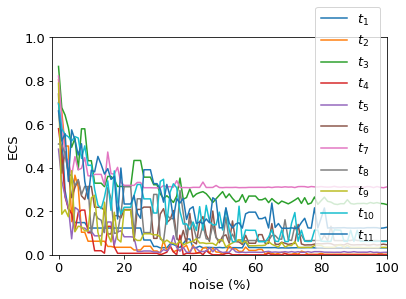

In [96]:
xs = np.arange(res+1)

for topic in sorted(sub_topics):
    ys = []
    for noise, topic_scores in pool_res:
        for topic_score in topic_scores:
            if topic_score[0] == topic:
                score = topic_scores[topic-1][1]
                ys.append(score)
    plt.plot(xs, ys, label="$t_{" + str(topic) + "}$")

#plt.rc('font', size=13)
plt.ylabel('ECS')
plt.xlabel('noise (%)')
plt.ylim(0, 1)
plt.xlim(-2, 100)
plt.legend()
#plt.savefig("simulation_with_noise.png", dpi=300)

In [51]:
over_ys_ncp = np.array(ys_ncp) + 1.96 * np.array(sd_ncp) / np.sqrt(11)
under_ys_ncp = np.array(ys_ncp) - 1.96 * np.array(sd_ncp) / np.sqrt(11)

over_ys_ncbp = np.array(ys_ncbp) + 1.96 * np.array(sd_ncbp) / np.sqrt(11)
under_ys_ncbp = np.array(ys_ncbp) - 1.96 * np.array(sd_ncbp) / np.sqrt(11)

over_ys_necs = np.array(ys_necs) + 1.96 * np.array(sd_necs) / np.sqrt(11)
under_ys_necs = np.array(ys_necs) - 1.96 * np.array(sd_necs) / np.sqrt(11)

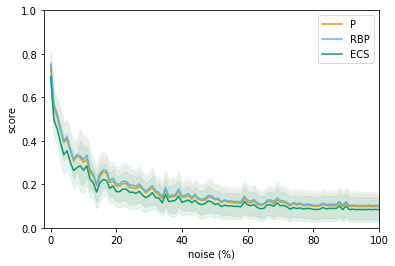

In [53]:
xs = np.arange(res+1)

plt.fill_between(xs, over_ys_ncp, under_ys_ncp, color='#E69F00', alpha=.1)
plt.fill_between(xs, over_ys_ncbp, under_ys_ncbp, color='#56B4E9', alpha=.1)
plt.fill_between(xs, over_ys_necs, under_ys_necs, color='#009E73', alpha=.1)

plt.plot(xs, ys_ncp, color='#E69F00', label='P')
plt.plot(xs, ys_ncbp, color='#56B4E9', label='RBP')
plt.plot(xs, ys_necs, color='#009E73', label='ECS')

#plt.rc('font', size=13)
plt.ylabel('score')
plt.xlabel('noise (%)')
plt.ylim(0, 1)
plt.xlim(-2, 100)
plt.legend()
#plt.savefig("simulation_with_noise_mean.png", dpi=300)

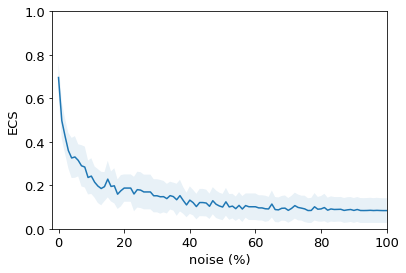

In [110]:
xs = np.arange(res+1)

plt.plot(xs, ys_ncp, color='#E69F00', label='P')
plt.fill_between(xs, over_ys_ncp, under_ys_ncp, color='#E69F00', alpha=.1)

plt.plot(xs, ys_ncbp, color='#56B4E9', label='RBP')
plt.fill_between(xs, over_ys_ncbp, under_ys_ncbp, color='#56B4E9', alpha=.1)

plt.plot(xs, ys_necs, color='#009E73', label='ECS')
plt.fill_between(xs, over_ys_necs, under_ys_necs, color='#009E73', alpha=.1)

#plt.rc('font', size=13)
plt.ylabel('score')
plt.xlabel('noise (%)')
plt.ylim(0, 1)
plt.xlim(-2, 100)
#plt.legend()
plt.savefig("simulation_with_noise_mean.png", dpi=300)

# Tables

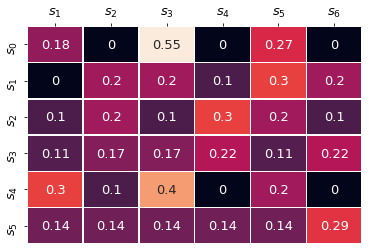

In [83]:
topic = 1

transitions_table = get_transitions_table(len(sub_topics[topic]), 
                                              min(sub_topics[topic]), 
                                              all_sequences[topic])

a = to_matrix(transitions_table)
plt.rc('font', size=13)
labels = np.copy(a)
labels = np.round_(labels, 2)
labels = labels.astype(str)
labels[a < 0.01] = "$\\varepsilon$"
labels[a == 0.0] = "0"
y_axis_labels = ["$s_0$", "$s_1$", "$s_2$", "$s_3$", "$s_4$", "$s_5$"]
x_axis_labels = ["$s_1$", "$s_2$", "$s_3$", "$s_4$", "$s_5$", "$s_6$"]
ax = sns.heatmap(a, xticklabels=x_axis_labels, yticklabels=y_axis_labels, vmin=0, vmax=0.5, annot=labels, linewidths=.5, fmt = '', cbar = False)
ax.xaxis.set_ticks_position('top')
plt.savefig("heat_map.png", dpi=300)

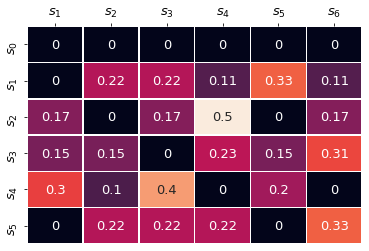

In [85]:
rel_table, irr_table, p_rel, _ = get_transitions_tables(num_subtopics, 
                                                        min(sub_topics[topic]), 
                                                        all_sequences[topic])

a = to_matrix(rel_table)
plt.rc('font', size=13)
labels = np.copy(a)
labels = np.round_(labels, 2)
labels = labels.astype(str)
labels[a < 0.01] = "$\\varepsilon$"
labels[a == 0.0] = "0"
y_axis_labels = ["$s_0$", "$s_1$", "$s_2$", "$s_3$", "$s_4$", "$s_5$"]
x_axis_labels = ["$s_1$", "$s_2$", "$s_3$", "$s_4$", "$s_5$", "$s_6$"]
ax = sns.heatmap(a, xticklabels=x_axis_labels, yticklabels=y_axis_labels, vmin=0, vmax=0.5, annot=labels, linewidths=.5, fmt = '', cbar = False)
ax.xaxis.set_ticks_position('top')
plt.savefig("heat_map_rel.png", dpi=300)

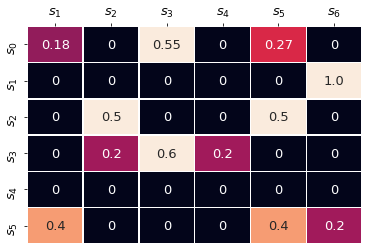

In [86]:
a = to_matrix(irr_table)
plt.rc('font', size=13)
labels = np.copy(a)
labels = np.round_(labels, 2)
labels = labels.astype(str)
labels[a < 0.01] = "$\\varepsilon$"
labels[a == 0.0] = "0"
y_axis_labels = ["$s_0$", "$s_1$", "$s_2$", "$s_3$", "$s_4$", "$s_5$"]
x_axis_labels = ["$s_1$", "$s_2$", "$s_3$", "$s_4$", "$s_5$", "$s_6$"]
ax = sns.heatmap(a, xticklabels=x_axis_labels, yticklabels=y_axis_labels, vmin=0, vmax=0.5, annot=labels, linewidths=.5, fmt = '', cbar = False)
ax.xaxis.set_ticks_position('top')
plt.savefig("heat_map_irr.png", dpi=300)